# Business questions
* 1. What neighbourhood are the expensive one and where do people pay less?
* 2. Do good review scores yield higher prices?
* 3. What attributes are most important for the price? 

# Import libraries

In [341]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline

# Read data and once again check for consistency

In [342]:
# read data
data =  pd.read_csv('Boston Airbnb/listings_preprocessed_new.csv', sep=',')
df = data.copy()

# display all columns at once
pd.set_option('display.max_columns', 50)
df.head()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,total_price_per_night
0,within an hour,100.0,100.0,0,1,1,1,0,Roslindale,42.282619,-71.133068,1,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,250.0,0.0,35.0,1,0.0,2,1125,0,91.975592,9.437089,9.26287,9.650712,9.653888,9.417185,9.17617,0,0,moderate,0,0,1,1.977237,267.5
1,within an hour,100.0,100.0,0,1,1,1,1,Roslindale,42.286241,-71.134374,1,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,65.0,95.0,10.0,0,0.0,2,15,36,94.000000,10.000000,9.00000,10.000000,10.000000,9.000000,9.00000,0,1,moderate,0,0,1,1.300000,70.0
2,within a few hours,100.0,88.0,1,1,1,1,1,Roslindale,42.292438,-71.135765,1,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,65.0,0.0,0.0,1,20.0,3,45,41,98.000000,10.000000,9.00000,10.000000,10.000000,9.000000,10.00000,0,0,moderate,1,0,1,0.470000,65.0
3,within a few hours,100.0,50.0,0,1,1,1,0,Roslindale,42.281106,-71.121021,0,House,Private room,4,1.0,1.0,2.0,Real Bed,75.0,100.0,50.0,2,25.0,1,1125,1,100.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.00000,0,0,moderate,0,0,1,1.000000,125.0
4,within an hour,100.0,100.0,1,1,1,1,1,Roslindale,42.284512,-71.136258,1,House,Private room,2,1.5,1.0,2.0,Real Bed,79.0,0.0,15.0,1,0.0,2,31,29,99.000000,10.000000,10.00000,10.000000,10.000000,9.000000,10.00000,0,0,flexible,0,0,1,2.250000,86.5


In [343]:
df.shape

(3256, 42)

# Correlations

In [344]:
# all different review columns
reviews = [i for i in df if 'review' in i] 
reviews = reviews+['total_price_per_night']

review_df = df.loc[:, reviews]
# review_df = review_df[]
review_df.head()


,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,total_price_per_night
0,0,91.975592,9.437089,9.26287,9.650712,9.653888,9.417185,9.17617,1.977237,267.5
1,36,94.000000,10.000000,9.00000,10.000000,10.000000,9.000000,9.00000,1.300000,70.0
2,41,98.000000,10.000000,9.00000,10.000000,10.000000,9.000000,10.00000,0.470000,65.0
3,1,100.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.00000,1.000000,125.0
4,29,99.000000,10.000000,10.00000,10.000000,10.000000,9.000000,10.00000,2.250000,86.5


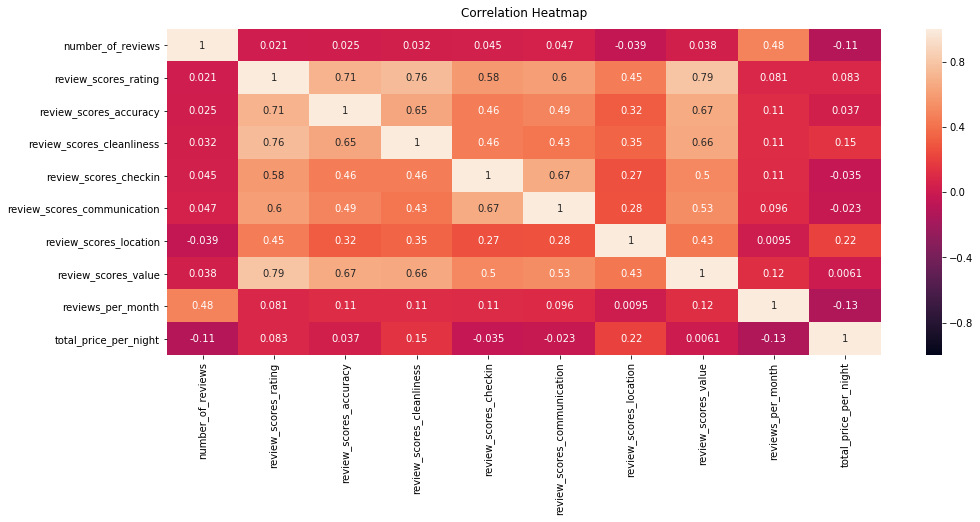

In [345]:
plt.figure(figsize=(16, 6))

# choose correlation method from {'pearson', 'kendall', 'spearman'}
heatmap = sns.heatmap(review_df.corr(method='pearson'), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);


#### different review scores are barely correlated with "total_price". The highest correlations can be seen in "review_score_cleanliness" and "review_scores_location"

# Model fit

#### In order to answer the 3 business questions, we are going to fit different models (Lineare Regression, Lasso Regression, k-nearest neighbour) on the data

# Dummies

#### First, we need to create dummies variables for "bed_type", "room_type". "property_type", "neighbourhood_cleansed", "cancellation_policy" and "host_response_time"

In [346]:
df.dtypes.sort_values()

is_location_exact                     int64
maximum_nights                        int64
number_of_reviews                     int64
accommodates                          int64
guests_included                       int64
requires_license                      int64
instant_bookable                      int64
require_guest_profile_picture         int64
minimum_nights                        int64
host_has_profile_pic                  int64
host_total_listings_count             int64
host_listings_count                   int64
host_is_superhost                     int64
require_guest_phone_verification      int64
calculated_host_listings_count        int64
host_identity_verified                int64
review_scores_value                 float64
review_scores_location              float64
review_scores_communication         float64
review_scores_checkin               float64
review_scores_cleanliness           float64
review_scores_accuracy              float64
review_scores_rating            

In [347]:
pd.get_dummies(df['bed_type']).head(5)

,Airbed,Couch,Futon,Pull-out Sofa,Real Bed
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1


### create dummy variables and add to df

In [348]:

# attributes to be converted to dummies
vars_to_dummies = ['neighbourhood_cleansed', 'property_type', 'room_type',
                   'bed_type', 'cancellation_policy', 'host_response_time']

for col in vars_to_dummies:
    # get dummies
    dummies_temp = pd.get_dummies(df[col])
    
    # dummy column names
    dummies_temp_cols = dummies_temp.columns
    
    # rename dummy columns
    dummies_temp.columns = ['{}={}'.format(col, i) for i in dummies_temp_cols]
    
    # add dummy columns to df
    df[dummies_temp.columns] = dummies_temp
    
    # remove original column from df
    df = df.drop(columns=[col])

print(df.columns)



Index(['host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'latitude',
       'longitude', 'is_location_exact', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'requires_license', 'instant_bookable',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count', 'reviews_per_month',
       'total_price_per_night', 'neighbourhood_cleansed=Allston',
       'neighbourhood_cleansed=Back Bay', 'neighbourhood_cleansed=Bay Village',
       'neighbourhood

In [349]:
df.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,...,property_type=Condominium,property_type=Dorm,property_type=Entire Floor,property_type=Guesthouse,property_type=House,property_type=Loft,property_type=Other,property_type=Townhouse,property_type=Villa,room_type=Entire home/apt,room_type=Private room,room_type=Shared room,bed_type=Airbed,bed_type=Couch,bed_type=Futon,bed_type=Pull-out Sofa,bed_type=Real Bed,cancellation_policy=flexible,cancellation_policy=moderate,cancellation_policy=strict,cancellation_policy=super_strict_30,host_response_time=a few days or more,host_response_time=within a day,host_response_time=within a few hours,host_response_time=within an hour
0,100.0,100.0,0,1,1,1,0,42.282619,-71.133068,1,4,1.5,2.0,3.0,250.0,0.0,35.0,1,0.0,2,1125,0,91.975592,9.437089,9.26287,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1
1,100.0,100.0,0,1,1,1,1,42.286241,-71.134374,1,2,1.0,1.0,1.0,65.0,95.0,10.0,0,0.0,2,15,36,94.000000,10.000000,9.00000,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1
2,100.0,88.0,1,1,1,1,1,42.292438,-71.135765,1,2,1.0,1.0,1.0,65.0,0.0,0.0,1,20.0,3,45,41,98.000000,10.000000,9.00000,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0
3,100.0,50.0,0,1,1,1,0,42.281106,-71.121021,0,4,1.0,1.0,2.0,75.0,100.0,50.0,2,25.0,1,1125,1,100.000000,10.000000,10.00000,...,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0
4,100.0,100.0,1,1,1,1,1,42.284512,-71.136258,1,2,1.5,1.0,2.0,79.0,0.0,15.0,1,0.0,2,31,29,99.000000,10.000000,10.00000,...,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1


In [350]:
df.shape

(3256, 89)

### select columns of interest

In [351]:
predictor_df = df.drop(columns=['latitude', 'longitude', 'price', 'cleaning_fee', 'maximum_nights', 'total_price_per_night'])
predictor_df.head(10)

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,security_deposit,guests_included,extra_people,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,...,property_type=Condominium,property_type=Dorm,property_type=Entire Floor,property_type=Guesthouse,property_type=House,property_type=Loft,property_type=Other,property_type=Townhouse,property_type=Villa,room_type=Entire home/apt,room_type=Private room,room_type=Shared room,bed_type=Airbed,bed_type=Couch,bed_type=Futon,bed_type=Pull-out Sofa,bed_type=Real Bed,cancellation_policy=flexible,cancellation_policy=moderate,cancellation_policy=strict,cancellation_policy=super_strict_30,host_response_time=a few days or more,host_response_time=within a day,host_response_time=within a few hours,host_response_time=within an hour
0,100.0,100.0,0,1,1,1,0,1,4,1.5,2.0,3.0,0.0,1,0.0,2,0,91.975592,9.437089,9.26287,9.650712,9.653888,9.417185,9.17617,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1
1,100.0,100.0,0,1,1,1,1,1,2,1.0,1.0,1.0,95.0,0,0.0,2,36,94.000000,10.000000,9.00000,10.000000,10.000000,9.000000,9.00000,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1
2,100.0,88.0,1,1,1,1,1,1,2,1.0,1.0,1.0,0.0,1,20.0,3,41,98.000000,10.000000,9.00000,10.000000,10.000000,9.000000,10.00000,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0
3,100.0,50.0,0,1,1,1,0,0,4,1.0,1.0,2.0,100.0,2,25.0,1,1,100.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.00000,0,...,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0
4,100.0,100.0,1,1,1,1,1,1,2,1.5,1.0,2.0,0.0,1,0.0,2,29,99.000000,10.000000,10.00000,10.000000,10.000000,9.000000,10.00000,0,...,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1
5,100.0,95.0,1,2,2,1,1,1,2,1.0,1.0,1.0,0.0,1,0.0,2,8,100.000000,10.000000,10.00000,10.000000,10.000000,9.000000,10.00000,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0
6,98.0,96.0,0,5,5,1,1,0,3,1.0,1.0,2.0,0.0,1,25.0,1,57,90.000000,10.000000,10.00000,10.000000,10.000000,9.000000,9.00000,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
7,100.0,100.0,1,2,2,1,1,1,2,2.0,1.0,1.0,0.0,1,15.0,1,67,96.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.00000,0,...,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0
8,100.0,100.0,1,1,1,1,1,1,2,1.0,1.0,2.0,0.0,2,0.0,2,65,96.000000,10.000000,10.00000,10.000000,10.000000,9.000000,10.00000,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1
9,100.0,100.0,1,2,2,1,1,1,5,1.0,2.0,2.0,200.0,4,25.0,4,33,94.000000,10.000000,9.00000,10.000000,10.000000,9.000000,9.00000,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1


# Prepare data for modeling

### split into training/test sets

In [352]:
X_train, X_test, y_train, y_test = train_test_split(predictor_df, df['total_price_per_night'], test_size=0.2, random_state=42)
print('observations train data = {}'.format(X_train.shape))
print('observations test data = {}'.format(X_test.shape))

# use a log transformation for the response due to the skeewed distribution
y_train = np.sqrt(pd.DataFrame(y_train))
y_test = np.sqrt(pd.DataFrame(y_test))

print('y_train shape = {}'.format(y_train.shape))
print('y_test shape = {}'.format(y_test.shape))

observations train data = (2604, 83)
observations test data = (652, 83)
y_train shape = (2604, 1)
y_test shape = (652, 1)


In [353]:
min(y_test.values)

array([4.69041576])

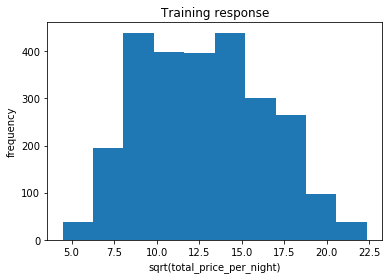

In [354]:
plt.figure()
plt.hist(y_train.values)
plt.xlabel('sqrt(total_price_per_night)')
plt.ylabel('frequency')
plt.title('Training response')
plt.show()

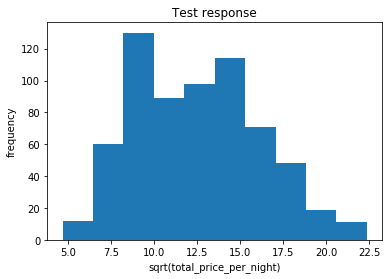

In [355]:
plt.figure()
plt.hist(y_test.values)
plt.xlabel('sqrt(total_price_per_night)')
plt.ylabel('frequency')
plt.title('Test response')
plt.show()

### Check out the 2 histograms above. The distribution in the training & test responses are similar and have the same range. This is good!

In [356]:
# StandardScaler?

In [357]:
# MinMaxScaler?

In [358]:
# LinearRegression?

### scale predictors in training data

In [359]:
# MinMaxScaler to scale the attributes to (0,1)
X_scaler = MinMaxScaler(feature_range=(0, 1))

# fit MinMaxScaler to the training data
X_scaled = X_scaler.fit(X_train)

# Make a copy of the original dataframe and overwrite this with the normalized values
X_train_scaled = X_train.copy()

# The [:] assignement is to overwrite the existing values of the dataframe with the normalized values
X_train_scaled[:] = X_scaled.transform(X_train)
print(X_train_scaled.head())



      host_response_rate  host_acceptance_rate  host_is_superhost  \
1315                1.00                  1.00                0.0   
1124                0.89                  0.45                0.0   
765                 1.00                  1.00                0.0   
818                 0.98                  0.68                0.0   
1149                0.71                  0.98                0.0   

      host_listings_count  host_total_listings_count  host_has_profile_pic  \
1315             0.004005                   0.004005                   1.0   
1124             0.744993                   0.744993                   1.0   
765              0.001335                   0.001335                   1.0   
818              0.032043                   0.032043                   1.0   
1149             0.484646                   0.484646                   1.0   

      host_identity_verified  is_location_exact  accommodates  bathrooms  \
1315                     0.0            

### scale response in training data

In [360]:
y_train.head()

,total_price_per_night
1315,18.929694
1124,18.069311
765,7.852813
818,14.730920
1149,14.854853


In [361]:
# same procedure as for the predictors above
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = y_scaler.fit(y_train)

y_train_scaled = y_train.copy()
y_train_scaled[:] = y_scaled.transform(y_train)
print(y_train_scaled.head())

print('')
print('min price scaled = {}'.format(np.min(y_train_scaled.values)))
print('max price scaled = {}'.format(np.max(y_train_scaled.values)))


      total_price_per_night
1315               0.808202
1124               0.760105
765                0.188986
818                0.573483
1149               0.580412

min price scaled = 0.0
max price scaled = 1.0


### test predictors

In [362]:

# copy of test predictors
X_test_scaled = X_test.copy()

# apply the "model" to the test to normalize them based on the min/max values "learned" on the training data
X_test_scaled[:] = X_scaler.transform(X_test)

X_test_scaled.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,security_deposit,guests_included,extra_people,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,...,property_type=Condominium,property_type=Dorm,property_type=Entire Floor,property_type=Guesthouse,property_type=House,property_type=Loft,property_type=Other,property_type=Townhouse,property_type=Villa,room_type=Entire home/apt,room_type=Private room,room_type=Shared room,bed_type=Airbed,bed_type=Couch,bed_type=Futon,bed_type=Pull-out Sofa,bed_type=Real Bed,cancellation_policy=flexible,cancellation_policy=moderate,cancellation_policy=strict,cancellation_policy=super_strict_30,host_response_time=a few days or more,host_response_time=within a day,host_response_time=within a few hours,host_response_time=within an hour
2351,1.00,0.00,1.0,0.001335,0.001335,1.0,0.0,1.0,1.0,0.571429,0.4,0.4,0.6,0.428571,0.250,0.000000,0.032178,0.975000,1.000000,1.000000,1.000000,1.000000,0.875000,0.875000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
134,0.92,0.94,0.0,0.001335,0.001335,1.0,1.0,1.0,0.2,0.285714,0.2,0.0,0.4,0.071429,0.050,0.034483,0.051980,0.887500,0.875000,1.000000,1.000000,1.000000,0.875000,0.875000,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2298,1.00,1.00,0.0,0.001335,0.001335,1.0,1.0,0.0,0.2,0.285714,0.2,0.0,0.0,0.071429,0.075,0.068966,0.007426,0.750000,1.000000,0.750000,1.000000,1.000000,1.000000,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1610,0.98,0.55,0.0,1.000000,1.000000,1.0,1.0,1.0,0.4,0.285714,0.2,0.0,0.0,0.071429,0.000,0.310345,0.000000,0.899695,0.929636,0.907859,0.956339,0.942315,0.927148,0.897021,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
990,1.00,0.77,0.0,0.001335,0.001335,1.0,1.0,1.0,0.4,0.285714,0.2,0.0,0.0,0.142857,0.250,0.000000,0.084158,0.875000,0.875000,0.875000,0.875000,1.000000,1.000000,0.875000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


# Model 1: Linear Regression

In [363]:
# instantiate linear model
lm = LinearRegression()

# fit linear model to scaled training data
lm.fit(X_train_scaled, y_train_scaled)

# show coefficients of regression
coef_df = pd.DataFrame({'attribute': X_train_scaled.columns, 'coefficient': lm.coef_.flatten()})
coef_df = coef_df.sort_values(by=['coefficient'], ascending=False)
print(coef_df)


                                       attribute   coefficient
82             host_response_time=within an hour  6.576063e+12
81         host_response_time=within a few hours  6.576063e+12
80               host_response_time=within a day  6.576063e+12
79         host_response_time=a few days or more  6.576063e+12
4                      host_total_listings_count  2.730186e+12
10                                      bedrooms  2.826871e-01
28                calculated_host_listings_count  1.900603e-01
13                               guests_included  1.663428e-01
8                                   accommodates  1.205910e-01
19                     review_scores_cleanliness  1.083712e-01
27              require_guest_phone_verification  7.753558e-02
18                        review_scores_accuracy  5.513638e-02
22                        review_scores_location  5.271752e-02
14                                  extra_people  4.911332e-02
12                              security_deposit  4.206

### Notice many coefficients being really large numbers. We can try a Lasso regression to improve the results but lets first take a look at some metrics such as R^2 and RMSE

In [364]:

# predict values for the scaled test predictors
y_pred = lm.predict(X_test_scaled)
print(y_pred[:5])

# rescale the predictions to prices in USD
y_pred_rescaled = y_scaler.inverse_transform(y_pred)
y_pred_rescaled[:5]

print('')
print('min price scaled = {}'.format(np.min(y_pred_rescaled)))
print('max price scaled = {}'.format(np.max(y_pred_rescaled)))

[[0.68066406]
 [0.29101562]
 [0.24853516]
 [0.50390625]
 [0.60253906]]

min price scaled = 4.716705890038619
max price scaled = 21.92394774814247


### R^2 and RMSE for the linear model

In [365]:
# R^2 value
r2_score(y_test, y_pred_rescaled)

0.7214534066407345

In [366]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rescaled))
print('RMSE = {}'.format(rmse))

# mae = mean_absolute_error(y_test, y_pred_rescaled)
# print('MAE = {}'.format(mae))

RMSE = 1.9181446639790083


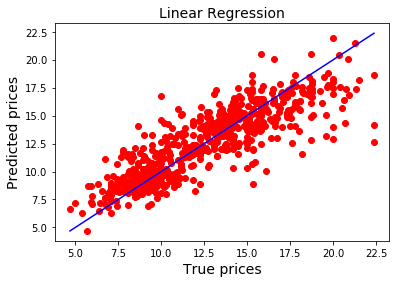

In [367]:
plt.scatter(y_test, y_pred_rescaled, c='red')
p1 = max(max(y_pred_rescaled), max(y_test.values))
p2 = min(min(y_pred_rescaled), min(y_test.values))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True prices', fontsize=14)
plt.ylabel('Predicted prices', fontsize=14)
plt.title('Linear Regression', fontsize=14)
plt.show()

### Although the coefficients are really large, we still obtain a model that looks ok. But maybe we can do better.

# Model 2: Lasso Regression

In [368]:
# {'alpha':list(np.round(np.arange(0.00005, 0.0003, 0.00001), 5))}

In [369]:
# GridSearchCV?

In [374]:
# instantiate
lm_lasso = Lasso(max_iter=5000)

# parameters lambda for the weights
# lambdas = {'alpha':[0.1, 0.5, 0.8, 1, 2, 3, 5, 10, 20]}
# lambdas = {'alpha':[0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]}
# lambdas = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1.0]}
# lambdas = {'alpha':[0.00005, 0.0001, 0.00015, 0.0002]}
lambdas = {'alpha':list(np.round(np.arange(0.00001, 0.0003, 0.00001), 6))}

# Grid Search including cross validation
lasso_models = GridSearchCV(lm_lasso, param_grid=lambdas, cv=10, refit=True)
lasso_models

# fit model
lasso_models.fit(X_train_scaled, y_train_scaled)

best_lasso = lasso_models.best_estimator_

print(best_lasso)

coef_df_lasso = pd.DataFrame({'attribute': X_train_scaled.columns, 'coefficient': best_lasso.coef_.flatten()})
coef_df_lasso = coef_df_lasso[coef_df_lasso['coefficient'] != 0]
coef_df_lasso = coef_df_lasso.sort_values(by=['coefficient'], ascending=False)
print(coef_df_lasso)


Lasso(alpha=4e-05, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
                                         attribute  coefficient
10                                        bedrooms     0.280500
64                             property_type=Other     0.166978
13                                 guests_included     0.158253
28                  calculated_host_listings_count     0.152511
57                              property_type=Boat     0.150138
67                       room_type=Entire home/apt     0.139659
51  neighbourhood_cleansed=South Boston Waterfront     0.138428
8                                     accommodates     0.118109
38                 neighbourhood_cleansed=Downtown     0.112665
19                       review_scores_cleanliness     0.102853
31                 neighbourhood_cleansed=Back Bay     0.096961
33              neighbourhood_cleansed=

### Evaluation of lasso model

In [331]:

# predict values for the scaled test predictors
y_pred_lasso = best_lasso.predict(X_test_scaled).reshape(-1,1)
y_pred_lasso[:5]

# rescale the predictions to prices in Euros
y_pred_rescaled_lasso = y_scaler.inverse_transform(y_pred_lasso)
y_pred_rescaled_lasso[:5]


array([[16.45658677],
       [ 9.72369128],
       [ 8.98771193],
       [13.40625598],
       [15.28412683]])

In [332]:
# R^2 value
r_squared = r2_score(y_test, y_pred_rescaled_lasso)
print('R^2 = {}'.format(r_squared))

R^2 = 0.7204522815864137


In [333]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rescaled_lasso))
print('RMSE = {}'.format(rmse))

# mae = mean_absolute_error(y_test, y_pred_rescaled_lasso)
# print('MAE = {}'.format(mae))

RMSE = 1.9215885767375434


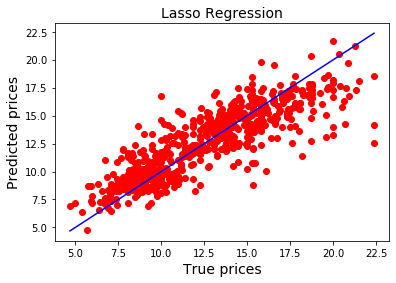

In [334]:
plt.scatter(y_test, y_pred_rescaled_lasso, c='red')
p1 = max(max(y_pred_rescaled_lasso), max(y_test.values))
p2 = min(min(y_pred_rescaled_lasso), min(y_test.values))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True prices', fontsize=14)
plt.ylabel('Predicted prices', fontsize=14)
plt.title('Lasso Regression', fontsize=14)
plt.show()

### Using Lasso Regression, we obtain a model that has $R^2 \approx 0.72$ which is not amazing but ok. The model improvement compared to the ordinary linear regression in terms of R^2 or RMSE is not very significant but the coefficients should be better interpretable

# Remark
### Our model is neither perfect nor close to perfect. Therefore we can only trust this model with a certain precaution

In [335]:
print(coef_df_lasso)

                                         attribute  coefficient
10                                        bedrooms     0.280500
64                             property_type=Other     0.166978
13                                 guests_included     0.158253
28                  calculated_host_listings_count     0.152511
57                              property_type=Boat     0.150138
67                       room_type=Entire home/apt     0.139659
51  neighbourhood_cleansed=South Boston Waterfront     0.138428
8                                     accommodates     0.118109
38                 neighbourhood_cleansed=Downtown     0.112665
19                       review_scores_cleanliness     0.102853
31                 neighbourhood_cleansed=Back Bay     0.096961
33              neighbourhood_cleansed=Beacon Hill     0.094377
78             cancellation_policy=super_strict_30     0.093520
32              neighbourhood_cleansed=Bay Village     0.086678
52                neighbourhood_cleansed

### Apparently good reviews for cleanliness and location have a positive influence on the price. Moreover the review score value, the number of reviews and the review score for checkin seem to have a negative influence on the price 

# Model 3: K-nearest neighbour

In [336]:
parameters = {'n_neighbors':[1, 3, 5, 10, 20], 'weights':['uniform', 'distance']}
knn_model = KNeighborsRegressor()
models = GridSearchCV(knn_model, parameters, cv=5, refit=True)
models.fit(X_train_scaled, y_train_scaled)
best_knn = models.best_estimator_
print(best_knn)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='distance')


In [337]:
y_pred_knn = best_knn.predict(X_test_scaled)
print(y_pred_knn[:5])

y_pred_knn_rescaled = y_scaler.inverse_transform(y_pred_knn)
print('')
print(y_pred_knn_rescaled[:5])

[[0.5771332 ]
 [0.28247459]
 [0.28170618]
 [0.49791377]
 [0.60010934]]

[[14.79620856]
 [ 9.52519509]
 [ 9.51144927]
 [13.37908816]
 [15.20721817]]


In [338]:
# R^2 value
r_squared = r2_score(y_test, y_pred_knn_rescaled)
print('')
print('R^2 = {}'.format(r_squared))

rmse = np.sqrt(mean_squared_error(y_pred_knn_rescaled, y_test))
print('')
print('RMSE = {}'.format(rmse))

# mae = mean_absolute_error(y_test, y_pred_knn_rescaled)
# print('MAE = {}'.format(mae))


R^2 = 0.6460948912044472

RMSE = 2.162100355932038


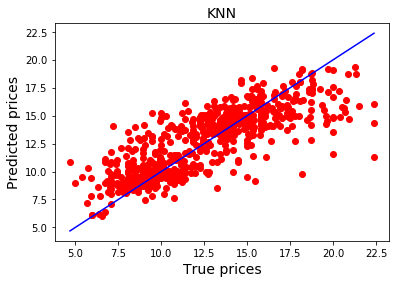

In [339]:
plt.scatter(y_test, y_pred_knn_rescaled, c='red')
p1 = max(max(y_pred_knn_rescaled), max(y_test.values))
p2 = min(min(y_pred_knn_rescaled), min(y_test.values))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True prices', fontsize=14)
plt.ylabel('Predicted prices', fontsize=14)
plt.title('KNN', fontsize=14)
plt.show()

# Conclusion

### Seems like the Lasso regression yields the best and most interpretable result. Therefore we are going to answer our questions according to the lasso model

# Business questions
* 1. What neighbourhood are the expensive one and where do people pay less?
* 2. Do good review scores yield higher prices?
* 3. What attributes are most important for the price? 

# Answers 1

In [405]:
nbh = [i for i in coef_df_lasso['attribute'] if 'neighbourhood' in i] 
nbh_indexes = [coef_df_lasso[coef_df_lasso['attribute']==nbh[i]].index[0] for i in range(len(nbh))]


In [404]:
coef_df_lasso.loc[nbh_indexes, :]

,attribute,coefficient
51,neighbourhood_cleansed=South Boston Waterfront,0.138428
38,neighbourhood_cleansed=Downtown,0.112665
31,neighbourhood_cleansed=Back Bay,0.096961
33,neighbourhood_cleansed=Beacon Hill,0.094377
32,neighbourhood_cleansed=Bay Village,0.086678
52,neighbourhood_cleansed=South End,0.081989
36,neighbourhood_cleansed=Chinatown,0.068390
40,neighbourhood_cleansed=Fenway,0.056750
47,neighbourhood_cleansed=North End,0.048096
50,neighbourhood_cleansed=South Boston,0.042242


###  You tend to pay more in the following neighbourhoods (closer to the coast/centre):
* South Boston Waterfront
* Downtown
* Back Bay
* Beacon Hill

### You tend to pay less in the following neighbourhoods (furhter away from the coast/centre):
* Hyde Park
* Roslindale
* Mattapan
* Dorchester

### More details in the table below 


# Answer 2

In [400]:
reviews = [i for i in coef_df_lasso['attribute'] if 'review' in i] 
reviews
review_indexes = [coef_df_lasso[coef_df_lasso['attribute']==reviews[i]].index[0] for i in range(len(reviews))]
review_indexes

[19, 18, 22, 17, 21, 20, 16, 23, 29]

In [401]:
coef_df_lasso.loc[review_indexes, :]

,attribute,coefficient
19,review_scores_cleanliness,0.102853
18,review_scores_accuracy,0.053564
22,review_scores_location,0.046060
17,review_scores_rating,0.025251
21,review_scores_communication,0.007692
20,review_scores_checkin,-0.029610
16,number_of_reviews,-0.070558
23,review_scores_value,-0.093094
29,reviews_per_month,-0.116215


### The following review score categories seem to have a positive influence on the price: 
* cleanliness
* accuracy
* location
* rating
* communication

### The following review score categories seem to have a negative influence on the price: 
* checkin
* number of reviews
* value
* reviews per month

### Discussion: We impute a few hundert review scores with the mean, which means these result may not be 100% accurate, especially because our model only has a fit of $R^2 \approx 0.72$

# Answer 3

In [408]:
coef_df_lasso.head(10)

,attribute,coefficient
10,bedrooms,0.280500
64,property_type=Other,0.166978
13,guests_included,0.158253
28,calculated_host_listings_count,0.152511
57,property_type=Boat,0.150138
67,room_type=Entire home/apt,0.139659
51,neighbourhood_cleansed=South Boston Waterfront,0.138428
8,accommodates,0.118109
38,neighbourhood_cleansed=Downtown,0.112665
19,review_scores_cleanliness,0.102853


In [409]:
coef_df_lasso.tail(10)

,attribute,coefficient
54,neighbourhood_cleansed=West Roxbury,-0.077384
37,neighbourhood_cleansed=Dorchester,-0.087187
59,property_type=Dorm,-0.090406
23,review_scores_value,-0.093094
3,host_listings_count,-0.099484
45,neighbourhood_cleansed=Mattapan,-0.101421
48,neighbourhood_cleansed=Roslindale,-0.108888
29,reviews_per_month,-0.116215
41,neighbourhood_cleansed=Hyde Park,-0.127372
15,minimum_nights,-0.137473


# Large positive influences on the price come from (not in order):
* bedrooms: number of bedrooms
* guests_included: number of guests
* property_type=boat
* room_type=entire home/apt
* neighbourhoods "South Boston Waterfron" & "Downtown"

### Obviously more beds and more people make place more expensive. Staying on a boat or in an entire home also seems to be more expensive than staying in, let's say, a shared room. Moreover staying in popular neighbourhood also drives the price
    

# Large negative influences on the price come from (not in order):
* minimum_nights
* neighbourhoods "Hyde Park", "Roslindale", "Mattapan"
* reviews_per_month
* property_type=dorm

### Obvisously staying more nights reduces the price per night. Some neighbourhoods listed just above seem to have cheaper prices and staying in a dorm is also cheaper than other places

### Our model is certainly not perfect, but these result mostly seem very plausible. It is indeed difficult to predict exact prices because we are lacking some information about the dataset and we made some assumptions on which observations to remove and for which we imputed values (which may not all have been correct)